Deep Convolutional Generative Adversarial Network

using tensorflow and keras to create AI imagery 


In [72]:
import tensorflow as tf

import imageio as iio

import glob

import matplotlib.pyplot as plt

import numpy as np

import os 

import PIL 

from tensorflow.keras import layers

import time as tim

from IPython import display

from tqdm import tqdm_notebook

In [61]:
# load in mnist dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [62]:
# train_images.shape[0]         #60,000 images 

train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')

train_images =(train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

create the models 

In [63]:
def make_gen_model(): # Make generator model 
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7,7,256) # batch size 

    model.add(layers.Conv2DTranspose(128,(5,5), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


In [64]:
def make_disc_model(): # Make Discriminatot model
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  # drop out layer to prevent overfitting

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

use untrained generator to create and image

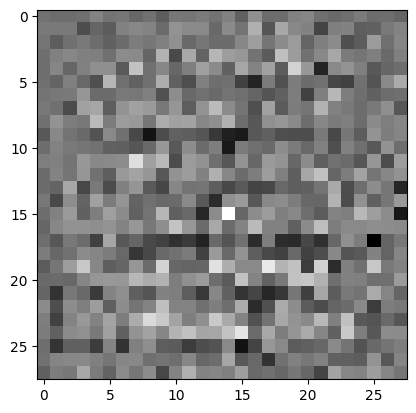

In [65]:
gen = make_gen_model()

noise = tf.random.normal([1,100])
gen_image = gen(noise,training = False )

plt.imshow(gen_image[0, :, :, 0], cmap='gray')

use untrained disc model to generate image 

In [66]:
disc = make_disc_model()

decision = disc(gen_image)

print(decision)

tf.Tensor([[-0.00011089]], shape=(1, 1), dtype=float32)


define loss and optimisers 


In [67]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [68]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=gen,
                                 discriminator=disc)

define training loop

In [69]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [70]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = gen(noise, training=True)

      real_output = disc(images, training=True)
      fake_output = disc(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

In [77]:
def train(dataset, epochs):
  for epoch in tqdm_notebook(range(epochs)):
    start = tim.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(gen,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, tim.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(gen,
                           epochs,
                           seed)

In [74]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

train the model 

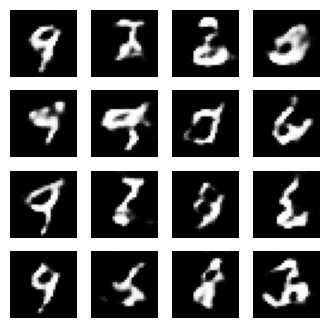

Time for epoch 23 is 82.7594084739685 sec


KeyboardInterrupt: 

In [78]:
train(train_dataset, EPOCHS)

use imageio to createa animated gif of images saved during training


In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)